C:\Users\flori\AppData\Local\Temp\ipykernel_58048\3942529388.py:6: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Cle                  1000 non-null   int64 
 1   Comptes              1000 non-null   int64 
 2   Duree_credit         1000 non-null   int64 
 3   Historique_credit    1000 non-null   object
 4   Objet_credit         1000 non-null   object
 5   Montant_credit       1000 non-null   int64 
 6   Epargne              1000 non-null   int64 
 7   Anciennete_emploi    1000 non-null   int64 
 8   Taux_effort          1000 non-null   int64 
 9   Situation_familiale  1000 non-null   object
 10  Garanties            1000 non-null   object
 11  Anciennete_domicile  1000 non-null   int64 
 12  Biens                1000 non-null   object
 13  Age                  1000 non-null   int64 
 14  Autres_credits       1000 non-null   object
 15  Statut_domicile      1000 non-null   object
 16  Nb_cred

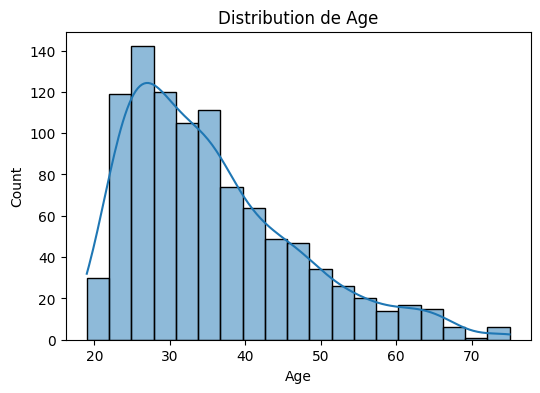

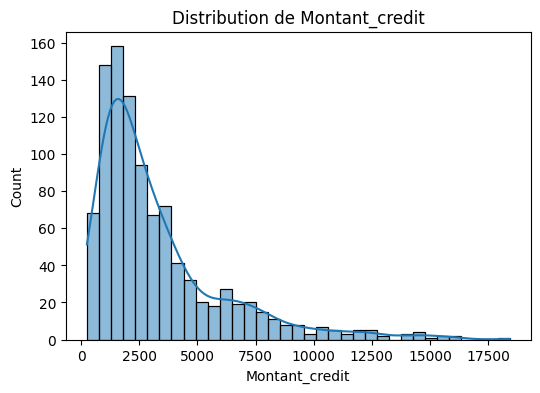

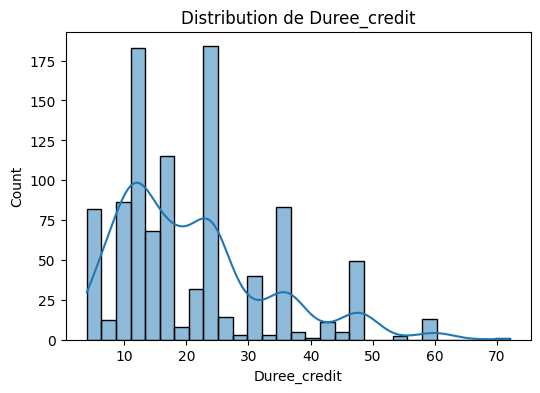

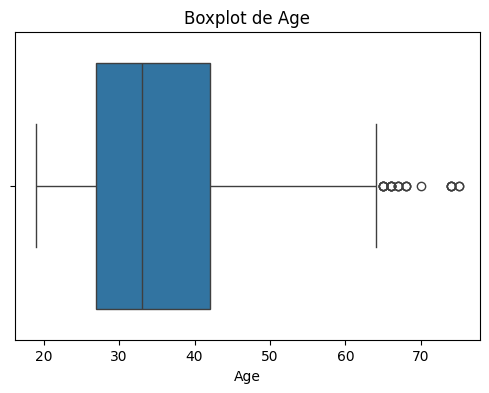

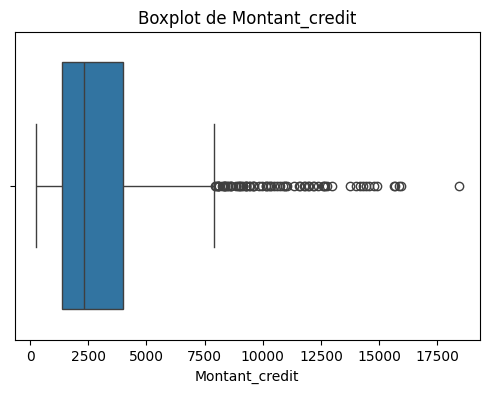

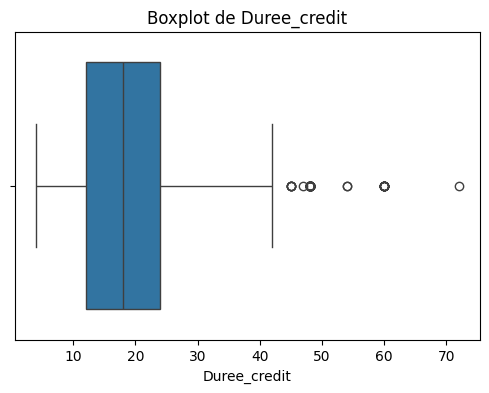

In [1]:
# %%
import pandas as pd
from pathlib import Path
import openpyxl as oxl
import numpy as np
import pkg_resources
from ydata_profiling import ProfileReport
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as ss

# %%
# --- Import des données ---
df = pd.read_excel(Path("data") / "credit.xlsx")
df.info()
# 1000 lignes, 21 colonnes
# 12 colonnes numériques (int64), 9 non numériques (object)

# %%
# Encodage de la variable cible : 1 -> 0, 2 -> 1 puis afficher
df["Cible"] = df["Cible"].map({1: 0, 2: 1})
df["Cible"].value_counts()

# %%
# --- Statistiques générales ---
ProfileReport(df, title="Rapport de données - Crédit")
# Pas de valeurs manquantes
# Garanties -> imbalanced
# Distributions semblent fortement assymétriques

# Corrélations fortes :
# entre Biens et Statut_domicile
# Montant_credit et Duree_credit

# A quoi correspondent les valeurs de :
# Historique_credit, Objet_credit, Situation_familiale, Garanties, Biens, Autres_credits, Statut_domicile, Type_emploi, Telephone

# %%
# Sélection des variables numériques et variables catégorielles
# Cle à exclure (car identification de l'observation)
# Variables numériques : Age, Montant_credit, Duree_credit
# Variables catégorielles : toutes les autres
var_num = df[["Age", "Montant_credit", "Duree_credit"]]
var_cat = df.drop(columns=["Cle", "Age", "Montant_credit", "Duree_credit"])

# %%
# --- Statistiques descriptives - Variables numériques ---
print("Statistiques descriptives variables numériques :")
var_num.describe()
# %%
# Distributions
%matplotlib inline
for col in var_num.columns:
    plt.figure(figsize=(6, 4))
    sns.histplot(var_num[col], kde=True)
    plt.title(f"Distribution de {col}")
    plt.show()
# Asymétrie pour Age, Montant_credit, et distribution irrégulière et asymétrique pour Duree_credit
# %%
# Boxplot
for col in var_num.columns:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x=var_num[col])
    plt.title(f"Boxplot de {col}")
    plt.show()
# 13 valeurs potentiellements atypiques dans Age
# Beaucoup dans Montant_credit
# 10 dans Duree_credit

In [2]:
import numpy as np
from scipy.stats import t

def esd_test(y, alpha=0.05, max_outliers=20):
    """
    Test ESD pour la détection de valeurs aberrantes.

    Parameters:
        y (array-like): Données numériques
        alpha (float): Niveau de signification
        max_outliers (int): Nombre maximal de valeurs aberrantes à tester

    Returns:
        results (dict): Contient
            - 'R': statistiques de test
            - 'lambda': valeurs critiques
            - 'no_outliers': indices des points considérés comme aberrants
    """
    y = np.array(y, dtype=float)
    n = len(y)

    R = np.zeros(max_outliers)
    lam = np.zeros(max_outliers)
    y_work = y.copy()
    outlier_indices = []

    for i in range(max_outliers):
        mean_y = np.mean(y_work)
        std_y = np.std(y_work, ddof=1)
        if std_y == 0:
            break

        # Calcul de la statistique absolue standardisée
        ares = np.abs(y_work - mean_y) / std_y
        R[i] = np.max(ares)
        max_idx = np.argmax(ares)

        # Calcul de la valeur critique
        p = 1 - alpha / (2 * (n - i))
        t_crit = t.ppf(p, n - i - 1)
        lam[i] = t_crit * (n - i - 1) / np.sqrt((n - i - 2 + t_crit**2) * (n - i))

        # Si le maximum dépasse la valeur critique, c'est un outlier
        if R[i] > lam[i]:
            outlier_indices.append(np.where(y == y_work[max_idx])[0][0])

        # Retirer la valeur la plus extrême pour l'itération suivante
        y_work = np.delete(y_work, max_idx)

    return {
        "R": R[:len(outlier_indices)],
        "lambda": lam[:len(outlier_indices)],
        "no_outliers": outlier_indices
    }

# Exemple d'utilisation
# y = np.array([10, 12, 12, 13, 100, 14, 15])
# result = esd_test(y)
# print(result)


In [3]:
# Application du test ESD de Rosner aux variables numériques avec affichage amélioré
for col in var_num.columns:
    data = var_num[col].dropna().values
    results = esd_test(data, alpha=0.05)

    # Conversion des valeurs pour affichage simple
    values = [int(data[i]) if np.issubdtype(data[i].dtype, np.integer) else float(data[i])
              for i in results["no_outliers"]]

    if values:
        print(f"Valeurs aberrantes détectées dans '{col}' : {values}")
    else:
        print(f"Aucune valeur aberrante détectée dans '{col}'.")


Aucune valeur aberrante détectée dans 'Age'.
Valeurs aberrantes détectées dans 'Montant_credit' : [18424, 15945, 15857, 15672, 15653, 14896, 14782, 14555, 14421, 14318, 14179, 14027, 13756]
Valeurs aberrantes détectées dans 'Duree_credit' : [72]


Le test ESD n'a détecté aucune valeur aberrante dans la variable 'Age', 13 valeurs aberrantes dans la variable 'Montant_credit' et 1 valeur aberrante dans la variable 'Duree_credit'.